In [51]:
from functools import partial
import os

import torch.nn as nn
from torchvision.models import vit_b_16
import torch

import argparse

from wb_data import WaterBirdsDataset, get_loader, get_transform_cub, log_data
from utils import evaluate, get_y_p

from wb_data import WaterBirdsDataset, get_loader, get_transform_cub, log_data
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
import pickle



In [15]:
NUM_CLASSES = 2


In [43]:
model = vit_b_16(weights='DEFAULT')
model.heads.head = nn.Linear(model.heads.head.in_features, NUM_CLASSES)


In [17]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [6]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

class_token True
conv_proj.weight True
conv_proj.bias True
encoder.pos_embedding True
encoder.layers.encoder_layer_0.ln_1.weight True
encoder.layers.encoder_layer_0.ln_1.bias True
encoder.layers.encoder_layer_0.self_attention.in_proj_weight True
encoder.layers.encoder_layer_0.self_attention.in_proj_bias True
encoder.layers.encoder_layer_0.self_attention.out_proj.weight True
encoder.layers.encoder_layer_0.self_attention.out_proj.bias True
encoder.layers.encoder_layer_0.ln_2.weight True
encoder.layers.encoder_layer_0.ln_2.bias True
encoder.layers.encoder_layer_0.mlp.0.weight True
encoder.layers.encoder_layer_0.mlp.0.bias True
encoder.layers.encoder_layer_0.mlp.3.weight True
encoder.layers.encoder_layer_0.mlp.3.bias True
encoder.layers.encoder_layer_1.ln_1.weight True
encoder.layers.encoder_layer_1.ln_1.bias True
encoder.layers.encoder_layer_1.self_attention.in_proj_weight True
encoder.layers.encoder_layer_1.self_attention.in_proj_bias True
encoder.layers.encoder_layer_1.self_attention.ou

In [103]:
for param in model.parameters():
    param.requires_grad = False

for param in model.heads.head.parameters():
    param.requires_grad = True

#for name, module in model.named_modules():
#    if "mlp" in name and isinstance(module, torch.nn.Linear):
#        for param in module.parameters():
#            param.requires_grad = True

 
#for name, module in model.named_modules():
#    if "encoder.ln" in name and isinstance(module, torch.nn.LayerNorm):
#        for param in module.parameters():
#            param.requires_grad = True
            
for name, param in model.named_parameters():
    if param.requires_grad:
            print(f"{name}: {param.requires_grad}")
    

heads.head.weight: True
heads.head.bias: True


In [79]:
model_orig = vit_b_16(weights='DEFAULT')
model_orig.heads.head = nn.Linear(model_orig.heads.head.in_features, NUM_CLASSES)
model_orig.load_state_dict(torch.load(
    "logs/vit_waterbirds.pth",map_location=torch.device('cpu')
    ))

C:\Users\elmop\AppData\Local\Temp\ipykernel_2628\694165624.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_orig.load_state_dict(torch.load(


<All keys matched successfully>

In [48]:
model2 = vit_b_16(weights='DEFAULT')
model2.heads.head = nn.Linear(model2.heads.head.in_features, NUM_CLASSES)
model2.load_state_dict(torch.load(
    "logs/dfr_model.pth",map_location=torch.device('cpu')
    ))

C:\Users\elmop\AppData\Local\Temp\ipykernel_2628\2038915333.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(


<All keys matched successfully>

In [62]:
def get_average_weights(weights):
    return np.mean(np.abs(weights), axis=0)

In [85]:
pre_weights = get_average_weights(model_orig.heads.head.weight.data.cpu().numpy()).reshape(24,32)
post_weights = get_average_weights(model2.heads.head.weight.data.cpu().numpy()).reshape(24,32)



In [88]:
get_average_weights(model_orig.heads.head.weight.data.cpu().numpy())

array([0.01830626, 0.02235575, 0.00833835, 0.02699391, 0.02060206,
       0.01995219, 0.00611646, 0.01830231, 0.0246583 , 0.01834028,
       0.01383743, 0.02366373, 0.00133346, 0.01861874, 0.02430937,
       0.02017697, 0.03148827, 0.02014955, 0.01804064, 0.00831476,
       0.02754985, 0.02006184, 0.02148975, 0.02641575, 0.02106895,
       0.02223359, 0.02473892, 0.03382029, 0.01422083, 0.01014928,
       0.01753642, 0.01015401, 0.0215077 , 0.02472897, 0.01626673,
       0.00729743, 0.00831608, 0.00807436, 0.02080179, 0.02502844,
       0.02631742, 0.02149939, 0.02259371, 0.01865695, 0.01096913,
       0.02877349, 0.0301591 , 0.02428733, 0.00559836, 0.02183447,
       0.01295124, 0.019241  , 0.02549515, 0.01580918, 0.00176506,
       0.0255167 , 0.02893443, 0.02277912, 0.01881113, 0.01260794,
       0.01142748, 0.0192177 , 0.02023828, 0.01637147, 0.01584621,
       0.00399646, 0.0074521 , 0.0188703 , 0.02362041, 0.01191296,
       0.00839442, 0.02468142, 0.01265522, 0.01573065, 0.01146

In [81]:

with open('logs/dfr_logreg.pth', 'rb') as file:
    logreg = pickle.load(file)
    
logreg.coef_

array([[-1.76279417e-01,  7.74005553e-03,  0.00000000e+00,
        -4.62019861e-03, -8.80223288e-02,  2.25294176e-01,
         2.59273193e-02,  7.71800328e-02, -1.40060034e-01,
        -4.00243120e-03,  1.55833653e-02,  4.34813259e-02,
         0.00000000e+00,  1.94763523e-01,  0.00000000e+00,
        -3.53125293e-02,  1.36334496e-02,  0.00000000e+00,
         6.29093744e-02,  3.75318990e-02, -1.55380183e-03,
         0.00000000e+00,  6.64236913e-03,  0.00000000e+00,
        -2.22451320e-02, -6.03873639e-04,  5.60020028e-02,
        -1.13932418e-02,  0.00000000e+00,  0.00000000e+00,
         4.26481149e-03,  0.00000000e+00,  2.81354667e-01,
        -8.15396970e-02, -2.79698514e-03,  3.45828436e-03,
         1.94607266e-02, -1.31708780e-01,  6.42645421e-02,
         0.00000000e+00, -6.00733465e-02, -6.41892642e-02,
         9.79751244e-02,  7.08849171e-03, -4.16071618e-03,
         0.00000000e+00,  0.00000000e+00,  5.25419767e-02,
        -6.66404394e-04,  0.00000000e+00,  1.35453843e-0

In [59]:
logreg_weights = np.abs(logreg.coef_)

In [146]:
def plot_weight_grids(avg_before_reshaped, avg_after_reshaped, cmap='CMRmap',title1 = "vit_waterbird", title2 = "dfr"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    vmin = min(avg_before_reshaped.min(), avg_after_reshaped.min())
    vmax = min(avg_before_reshaped.max(), avg_after_reshaped.max())##set to max to change colour scale

    im1 = axes[0].imshow(avg_before_reshaped, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    axes[0].set_title(title1)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(avg_after_reshaped, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    axes[1].set_title(title2)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()




**last layer retrained**

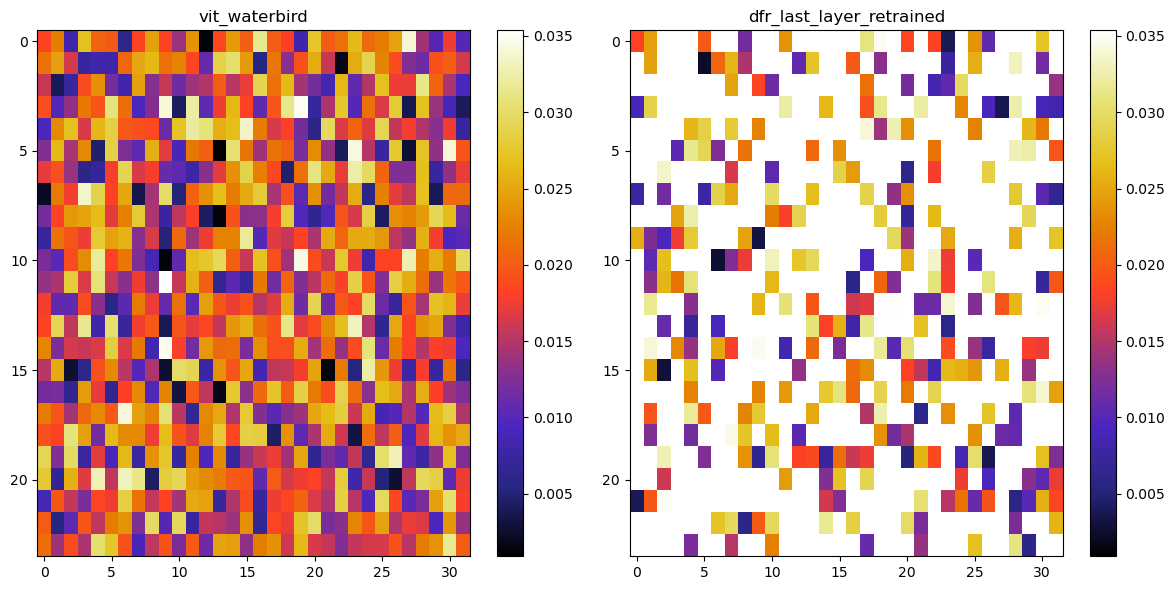

In [147]:
plot_weight_grids(pre_weights, post_weights, title2="dfr_last_layer_retrained")

**logreg**

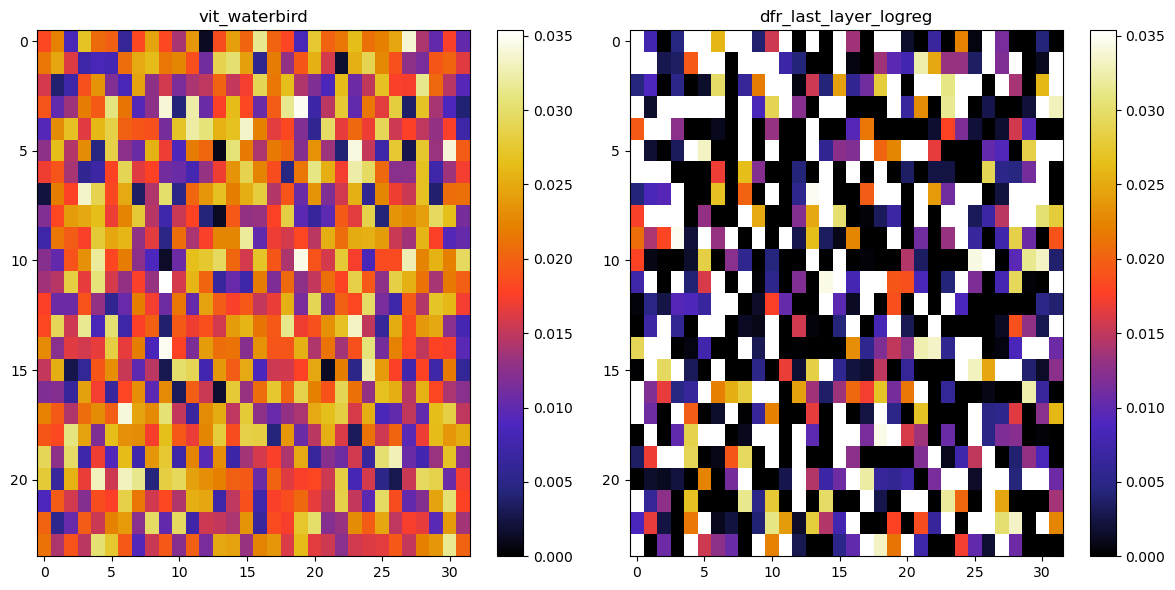

In [141]:
plot_weight_grids(pre_weights, logreg_weights.reshape(24,32), title2="dfr_last_layer_logreg")


In [138]:
scaler = MinMaxScaler(feature_range=(0, 1))
nr_pre = scaler.fit_transform(pre_weights)
nr_post = scaler.fit_transform(post_weights)
nr_logreg = scaler.fit_transform(logreg_weights.reshape(24,32))

**Normalised**

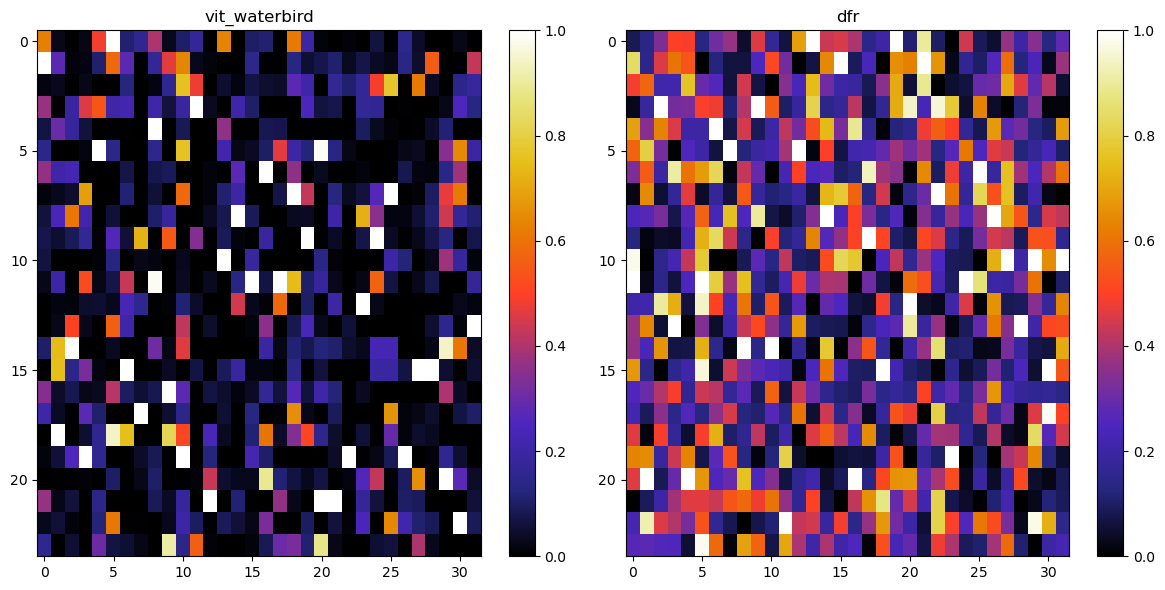

In [145]:
plot_weight_grids(nr_logreg, nr_post) ## testing how they look normalised


In [142]:
np.max(nr_post)

1.0000001

In [143]:
model2.heads.head.weight.data.cpu().numpy().shape


(2, 768)

In [144]:
one = np.abs(model2.heads.head.weight.data.cpu().numpy()[0,:]).reshape(24,32)
two = np.abs(model2.heads.head.weight.data.cpu().numpy()[1,:]).reshape(24,32)



**W1 vs W2**

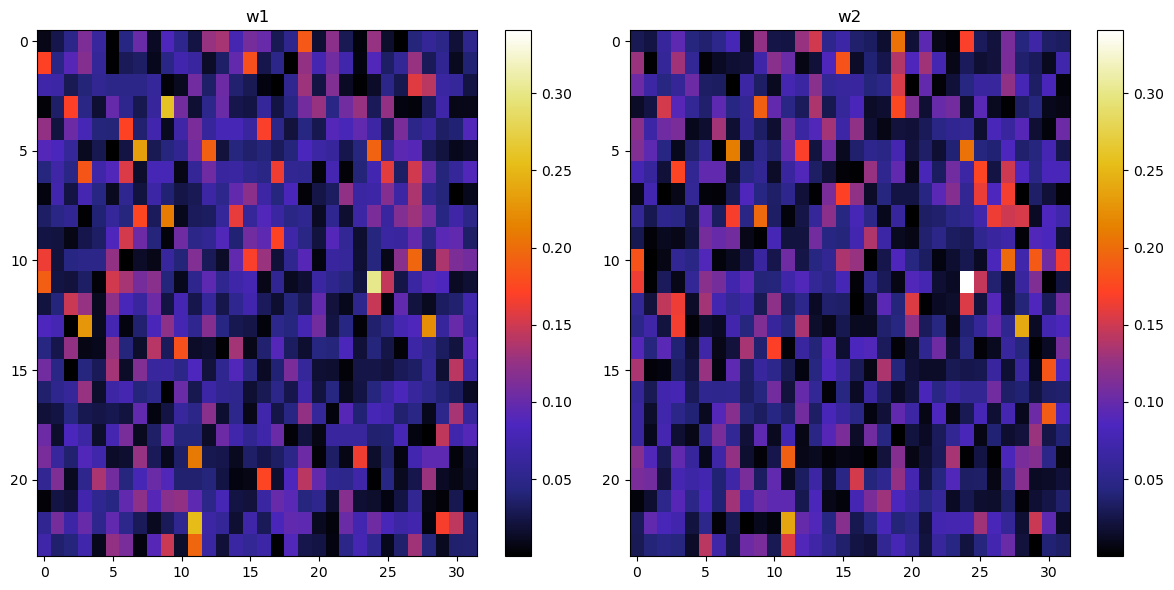

In [133]:
plot_weight_grids(one, two)